# 🧬 Cancer Risk Classification — From Risk Factors to Reliable Predictions  

<style>
:root{
  --card-bg: linear-gradient(135deg, #ffffff 0%, #f1f5f9 45%, #e2e8f0 100%);
  --card-fg: #0f172a;
  --card-border: rgba(15,23,42,0.18);
  --card-shadow: 0 0 40px rgba(2,6,23,0.10);
  --code-bg: rgba(148,163,184,0.22);
}
@media (prefers-color-scheme: dark){
  :root{
    --card-bg: linear-gradient(135deg, #020617 0%, #0f172a 45%, #1f2937 100%);
    --card-fg: #e5e7eb;
    --card-border: rgba(148,163,184,0.35);
    --card-shadow: 0 0 40px rgba(15,23,42,0.75);
    --code-bg: rgba(148,163,184,0.20);
  }
}
html[data-color-mode="dark"],
html[data-theme="dark"],
body[data-theme="dark"],
body.theme-dark,
html.theme-dark{
  --card-bg: linear-gradient(135deg, #020617 0%, #0f172a 45%, #1f2937 100%);
  --card-fg: #e5e7eb;
  --card-border: rgba(148,163,184,0.35);
  --card-shadow: 0 0 40px rgba(15,23,42,0.75);
  --code-bg: rgba(148,163,184,0.20);
}
html[data-color-mode="light"],
html[data-theme="light"],
body[data-theme="light"],
body.theme-light,
html.theme-light{
  --card-bg: linear-gradient(135deg, #ffffff 0%, #f1f5f9 45%, #e2e8f0 100%);
  --card-fg: #0f172a;
  --card-border: rgba(15,23,42,0.18);
  --card-shadow: 0 0 40px rgba(2,6,23,0.10);
  --code-bg: rgba(148,163,184,0.22);
}
.kgl-card{
  padding:26px 30px;
  background:var(--card-bg) !important;
  border-radius:18px;
  border:1px solid var(--card-border) !important;
  color:var(--card-fg) !important;
  line-height:1.7;
  margin:26px 0 34px 0;
  box-shadow:var(--card-shadow) !important;
}
.kgl-card *{
  color:var(--card-fg) !important;
}
.kgl-card code{
  background:var(--code-bg) !important;
  padding:2px 6px !important;
  border-radius:6px !important;
}
</style>

<div class="kgl-card">

<p style="margin:0 0 14px 0;">
<b>TL;DR:</b> End-to-end, leakage-aware ML pipeline to predict <b>cancer type</b> and 
<b>risk level</b> from patient risk factors — with strong baselines, macro-F1 evaluation, 
and interpretable diagnostics.
</p>

<p style="margin:0 0 16px 0;">
Each patient profile — demographics, lifestyle, family history, and clinical indicators — 
carries signals about both <b>which cancer type</b> may be present and 
<b>how severe the overall risk</b> is. This notebook walks through a complete workflow on 
healthcare-style tabular data, with a focus on <b>fair, trustworthy evaluation</b> rather 
than just chasing accuracy.
</p>

<h3 style="margin:4px 0 10px 0; font-size:30px; font-weight:700;">
What’s inside
</h3>

<ul style="margin:0 0 0 1.1rem; padding:0;">
  <li style="margin:4px 0;">
    <b>Dataset card &amp; baselines:</b> Target distributions and majority-class baselines using macro-F1.
  </li>
  <li style="margin:4px 0;">
    <b>Clinical EDA:</b> Age/BMI risk bins and lifestyle patterns (e.g. smoking, alcohol, obesity) vs 
    <code>Risk_Level</code>.
  </li>
  <li style="margin:4px 0;">
    <b>Leakage-aware modeling:</b> Careful handling of <code>Risk_Level</code> and 
    <code>Overall_Risk_Score</code> when training each task.
  </li>
  <li style="margin:4px 0;">
    <b>Models &amp; metrics:</b> Logistic Regression, Random Forest, Gradient Boosting 
    (XGBoost) with cross-validated macro-F1 and holdout reports.
  </li>
  <li style="margin:4px 0;">
    <b>Reliability &amp; interpretability:</b> Confusion matrices, calibration curves, permutation 
    importance, and subgroup performance by age.
  </li>
</ul>

</div>


## 🧾 Data Dictionary  

| Feature | Description |
|--------|-------------|
| **Patient_ID** | Unique patient identifier (dropped before modeling). |
| **Age** | Patient age in years. |
| **BMI** | Body Mass Index (weight/height ratio). |
| **Smoking, Alcohol_Use, Obesity** | Lifestyle flags indicating behavioral risk factors (Yes/No). |
| **Family_History, BRCA_Mutation, H_Pylori_Infection** | Clinical / genetic risk indicators related to cancer susceptibility. |
| **Overall_Risk_Score** | Combined numeric risk score; treated carefully as a potential leakage source. |
| **Risk_Level** | Derived categorical risk tier (Low / Medium / High); used either as a target or excluded as leakage depending on the task. |
| **Cancer_Type** | Main multiclass target label indicating the diagnosed cancer type. |


## Environment & Config 

In [1]:

import sys, warnings, os, random, inspect
warnings.filterwarnings("ignore")

# Core libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

# Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyClassifier

from scipy.stats import randint

#  XGBoost (fallback-safe)
try:
    from xgboost import XGBClassifier
    HAVE_XGB = True
except Exception:
    HAVE_XGB = False

# persistence
try:
    import joblib
    HAVE_JOBLIB = True
except Exception:
    HAVE_JOBLIB = False

# Global config
RANDOM_STATE = 42
FAST_MODE = True            # switch to False if you want deeper searches
MAX_ROWS_FOR_PLOTS = 2000   # cap for heavy plots
DISABLE_PAIRPLOT = True     # set False if you want pairplots
VERBOSE = True

def info(msg: str):
    if VERBOSE:
        print(f"[INFO] {msg}")

# Plot style
plt.rcParams.update({
    "figure.figsize": (7, 4.5),
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
})
sns.set_theme(style="ticks", context="notebook")

# Reproducibility
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)


## Load Data & Quick Inspection  


In [2]:
local_path = "cancer-risk-factors.csv"
kaggle_path = "/kaggle/input/cancer-risk-factors-dataset/cancer-risk-factors.csv"

DATA_PATH = local_path if os.path.exists(local_path) else kaggle_path
print(f" Using data from: {DATA_PATH}")

df = pd.read_csv(DATA_PATH)
print(" Loaded successfully!")
print("Shape:", df.shape)

display(df.head())

print("\nDtypes:")
print(df.dtypes)

print("\nNulls per column:")
print(df.isna().sum())

print("\nDuplicate rows:", int(df.duplicated().sum()))

if "Patient_ID" in df.columns:
    print("\nPatient_ID unique:", df["Patient_ID"].is_unique)

num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_all = [c for c in df.columns if c not in num_cols_all]

info(f"Numeric columns: {len(num_cols_all)} | Categorical columns: {len(cat_cols_all)}")

display(df[num_cols_all].describe().T)


 Using data from: /kaggle/input/cancer-risk-factors-dataset/cancer-risk-factors.csv
 Loaded successfully!
Shape: (2000, 21)


,Patient_ID,Cancer_Type,Age,Gender,Smoking,Alcohol_Use,Obesity,Family_History,Diet_Red_Meat,Diet_Salted_Processed,...,Physical_Activity,Air_Pollution,Occupational_Hazards,BRCA_Mutation,H_Pylori_Infection,Calcium_Intake,Overall_Risk_Score,BMI,Physical_Activity_Level,Risk_Level
0,LU0000,Breast,68,0,7,2,8,0,5,3,...,4,6,3,1,0,0,0.398696,28.0,5,Medium
1,LU0001,Prostate,74,1,8,9,8,0,0,3,...,1,3,3,0,0,5,0.424299,25.4,9,Medium
2,LU0002,Skin,55,1,7,10,7,0,3,3,...,1,8,10,0,0,6,0.605082,28.6,2,Medium
3,LU0003,Colon,61,0,6,2,2,0,6,2,...,6,4,8,0,0,8,0.318449,32.1,7,Low
4,LU0004,Lung,67,1,10,7,4,0,6,3,...,9,10,9,0,0,5,0.524358,25.1,2,Medium



Dtypes:
Patient_ID                  object
Cancer_Type                 object
Age                          int64
Gender                       int64
Smoking                      int64
Alcohol_Use                  int64
Obesity                      int64
Family_History               int64
Diet_Red_Meat                int64
Diet_Salted_Processed        int64
Fruit_Veg_Intake             int64
Physical_Activity            int64
Air_Pollution                int64
Occupational_Hazards         int64
BRCA_Mutation                int64
H_Pylori_Infection           int64
Calcium_Intake               int64
Overall_Risk_Score         float64
BMI                        float64
Physical_Activity_Level      int64
Risk_Level                  object
dtype: object

Nulls per column:
Patient_ID                 0
Cancer_Type                0
Age                        0
Gender                     0
Smoking                    0
Alcohol_Use                0
Obesity                    0
Family_History      

,count,mean,std,min,25%,50%,75%,max
Age,2000.0,63.248000,10.462946,25.000000,56.000000,64.000000,70.000000,90.000000
Gender,2000.0,0.489000,0.500004,0.000000,0.000000,0.000000,1.000000,1.000000
Smoking,2000.0,5.157000,3.325339,0.000000,2.000000,5.000000,8.000000,10.000000
Alcohol_Use,2000.0,5.035000,3.260996,0.000000,2.000000,5.000000,8.000000,10.000000
Obesity,2000.0,5.967500,3.061393,0.000000,4.000000,6.000000,9.000000,10.000000
Family_History,2000.0,0.194500,0.395914,0.000000,0.000000,0.000000,0.000000,1.000000
Diet_Red_Meat,2000.0,5.189500,3.154452,0.000000,3.000000,5.000000,8.000000,10.000000
Diet_Salted_Processed,2000.0,4.563500,3.088323,0.000000,2.000000,4.000000,7.000000,10.000000
Fruit_Veg_Intake,2000.0,4.927500,3.045305,0.000000,3.000000,5.000000,8.000000,10.000000
Physical_Activity,2000.0,4.015000,2.978458,0.000000,1.000000,4.000000,6.000000,10.000000


## Dataset Card & Problem Setup  

We treat this notebook as a mini-project, not just code:

- **Targets**
  - `Cancer_Type` — multiclass classification (cancer category).
  - `Risk_Level` — categorical risk tier (Low / Medium / High).
- **Inputs**
  - Demographics (`Age`, `BMI`, …)
  - Lifestyle (`Smoking`, `Alcohol_Use`, `Obesity`, …)
  - Genetic / clinical flags (`Family_History`, `BRCA_Mutation`, `H_Pylori_Infection`, …)
  - Aggregate risk score (`Overall_Risk_Score`)

We also compute simple **baseline models** (always predict majority class) to understand how much  
our ML models improve over naive guessing.


## Dataset Card & Baseline

In [3]:
required_targets = ["Cancer_Type", "Risk_Level"]
for col in required_targets:
    assert col in df.columns, f"Required target column '{col}' is missing."

print(" Target distributions (normalized):\n")
for tgt in required_targets:
    print(f"[{tgt}]")
    print(df[tgt].value_counts(normalize=True).round(3))
    print("-" * 40)

# Potential leakage-related columns (defined early for reuse)
LEAKY_COLS = []
if "Risk_Level" in df.columns:
    LEAKY_COLS.append("Risk_Level")
if "Overall_Risk_Score" in df.columns:
    LEAKY_COLS.append("Overall_Risk_Score")

LEAKY_COLS = list(dict.fromkeys(LEAKY_COLS))  # unique, keep order
print(" Potentially leaky columns:", LEAKY_COLS)

# Drop identifier from modeling
if "Patient_ID" in df.columns:
    df = df.drop(columns=["Patient_ID"])
    print("Dropped identifier column: Patient_ID")

# Dummy baselines (majority-class)
def compute_dummy_baseline(target_col: str):
    # Use all non-leaky, non-target columns as "features"
    X_dummy = df.drop(columns=[target_col] + [c for c in LEAKY_COLS if c != target_col])
    y_dummy = df[target_col]

    dummy = DummyClassifier(strategy="most_frequent")
    scores = cross_val_score(
        dummy, X_dummy, y_dummy,
        cv=5, scoring="f1_macro"
    )
    print(f"[{target_col}] Dummy F1-macro: {scores.mean():.3f} ± {scores.std():.3f}")

print("\n Baseline performance (always predict majority class):")
for tgt in required_targets:
    compute_dummy_baseline(tgt)


 Target distributions (normalized):

[Cancer_Type]
Cancer_Type
Lung        0.264
Breast      0.230
Colon       0.209
Prostate    0.152
Skin        0.145
Name: proportion, dtype: float64
----------------------------------------
[Risk_Level]
Risk_Level
Medium    0.787
Low       0.162
High      0.051
Name: proportion, dtype: float64
----------------------------------------
 Potentially leaky columns: ['Risk_Level', 'Overall_Risk_Score']
Dropped identifier column: Patient_ID

 Baseline performance (always predict majority class):
[Cancer_Type] Dummy F1-macro: 0.083 ± 0.000
[Risk_Level] Dummy F1-macro: 0.294 ± 0.000


## Leakage Probe — `Risk_Level` vs `Overall_Risk_Score`  

We want to know if `Risk_Level` is a deterministic mapping of `Overall_Risk_Score`.  
If yes, using both during modeling can create severe leakage.


In [4]:

assert "Cancer_Type" in df.columns, "Cancer_Type column is required"
assert "Risk_Level" in df.columns, "Risk_Level column is required"
assert "Overall_Risk_Score" in df.columns, "Overall_Risk_Score column is required"

print("Target candidates:")
print(" - Cancer_Type (unique classes):", df["Cancer_Type"].nunique())
print(" - Risk_Level (unique classes):", df["Risk_Level"].unique())

ranges = df.groupby("Risk_Level")["Overall_Risk_Score"].agg(["min", "max", "nunique"])
print("\nOverall_Risk_Score ranges per Risk_Level:")
display(ranges)

score_map_unique = df.groupby("Overall_Risk_Score")["Risk_Level"].nunique().le(1).all()
print(f"\nIs each Overall_Risk_Score mapped to a unique Risk_Level? → {score_map_unique}")

print("\nℹ️ We will treat both Risk_Level and Overall_Risk_Score as leakage-prone signals")
print("   and exclude them appropriately when predicting each target.")


Target candidates:
 - Cancer_Type (unique classes): 5
 - Risk_Level (unique classes): ['Medium' 'Low' 'High']

Overall_Risk_Score ranges per Risk_Level:


,min,max,nunique
Risk_Level,,,
High,0.660797,0.852158,102
Low,0.029285,0.329922,324
Medium,0.330033,0.659130,1574



Is each Overall_Risk_Score mapped to a unique Risk_Level? → True

ℹ️ We will treat both Risk_Level and Overall_Risk_Score as leakage-prone signals
   and exclude them appropriately when predicting each target.


## Exploratory Data Analysis (EDA)
We explore:

- Distributions of key numeric features (`Age`, `BMI`, `Overall_Risk_Score`)
- Class distributions of `Cancer_Type` and `Risk_Level`
- Correlations between numeric features
- Risk patterns across age groups and BMI groups
- Lifestyle factors vs Risk_Level
- Joint distribution of Cancer_Type within each Risk_Level


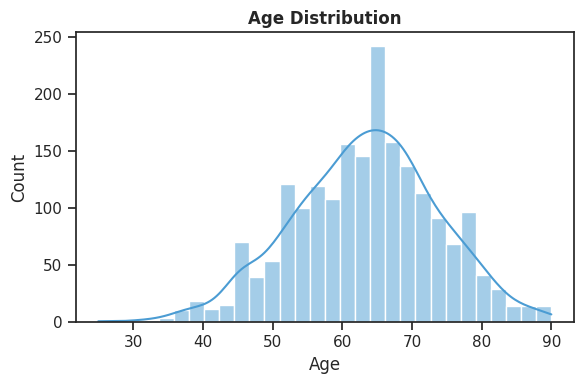

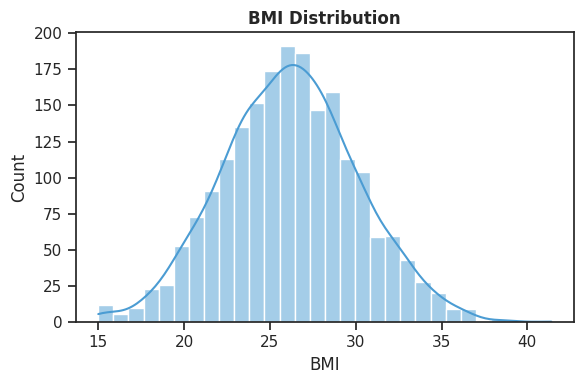

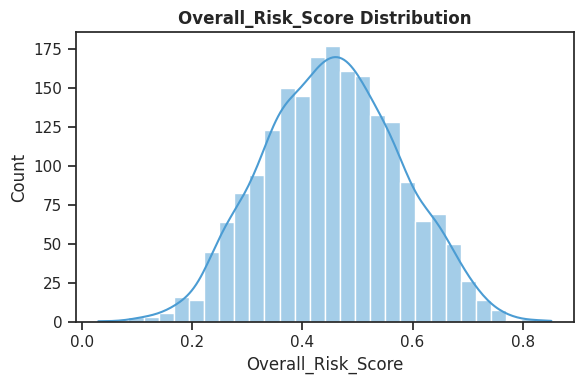

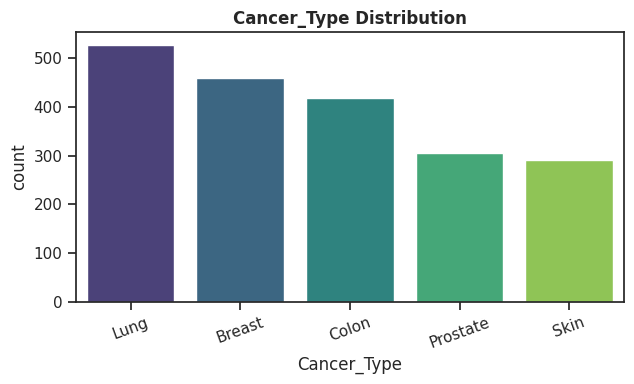

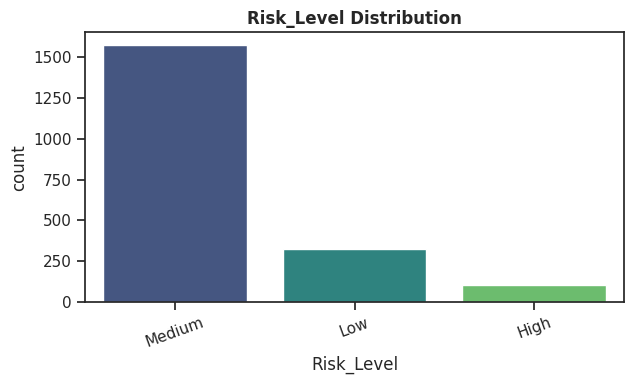

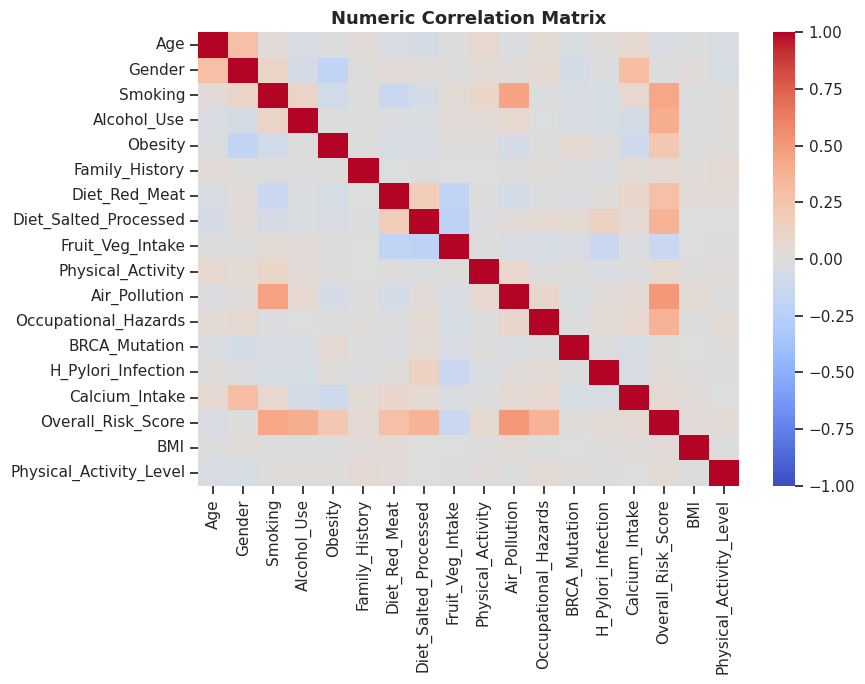

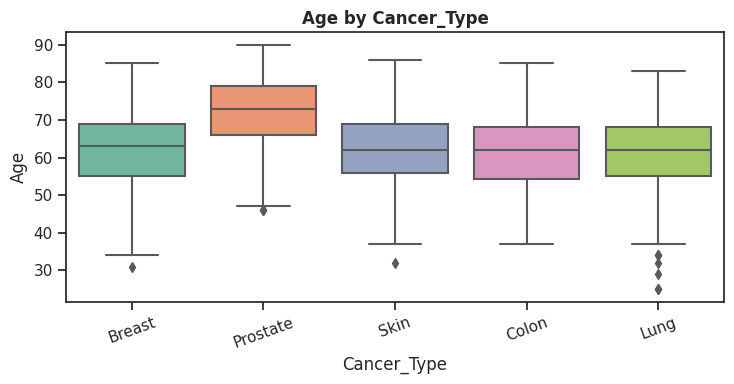

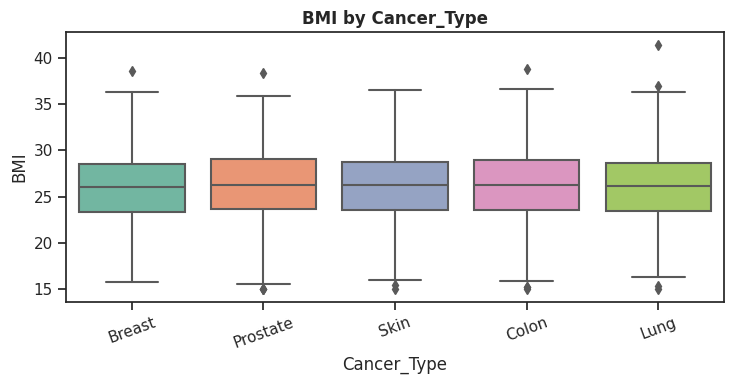

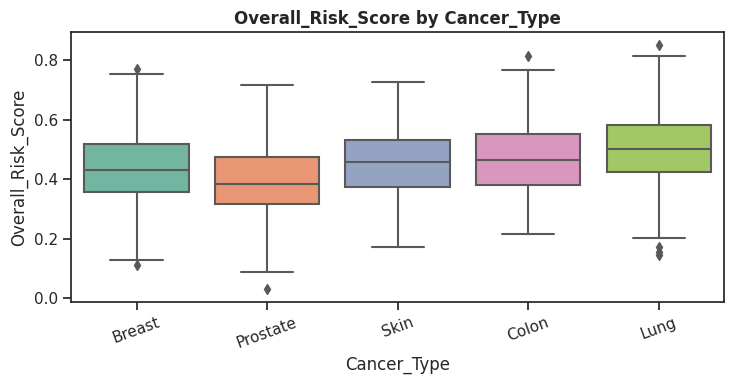

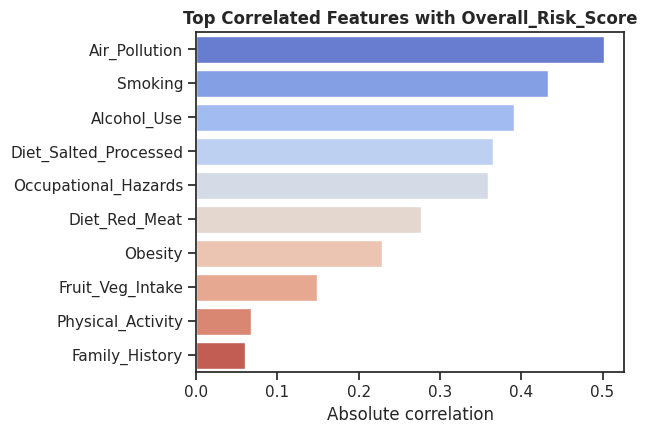

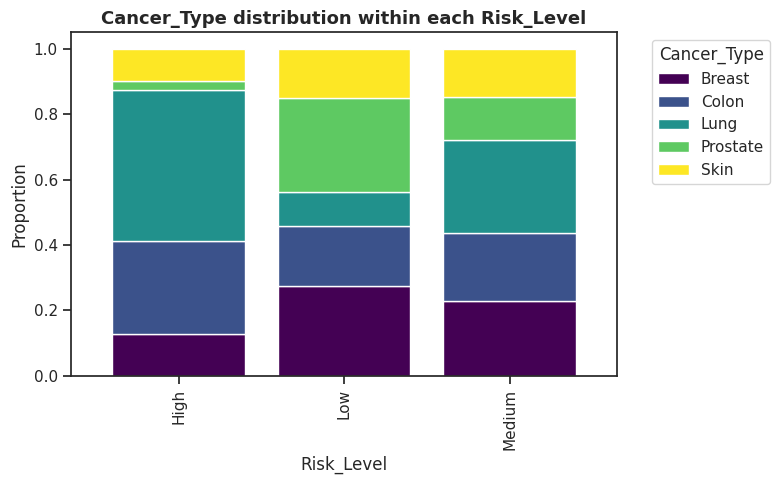

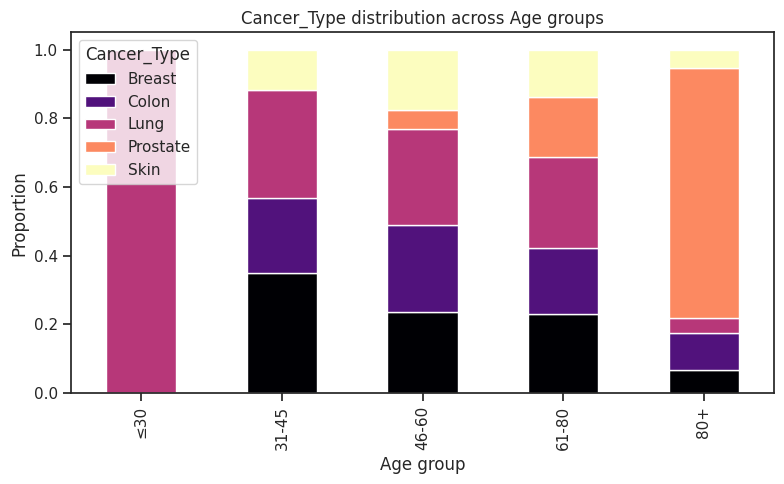

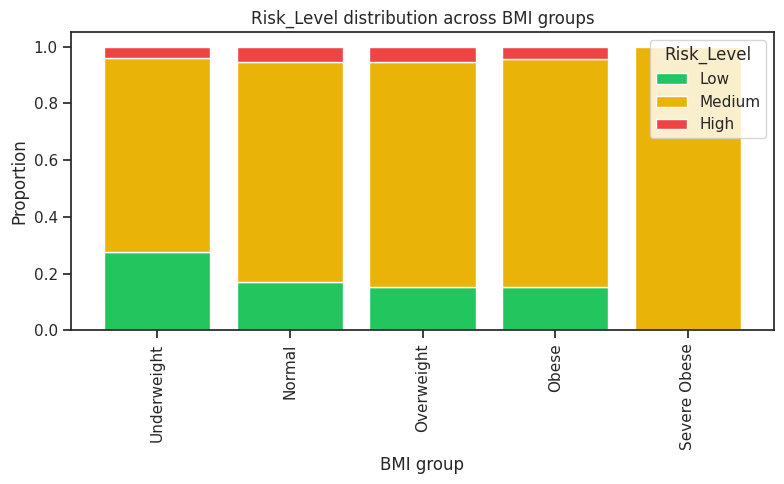

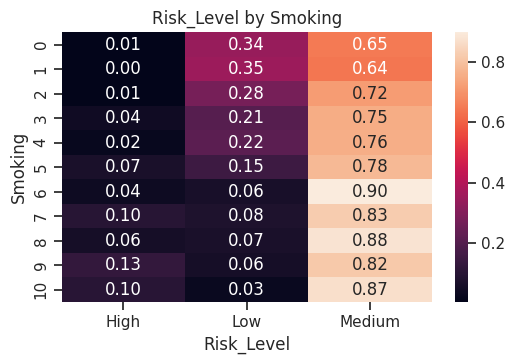

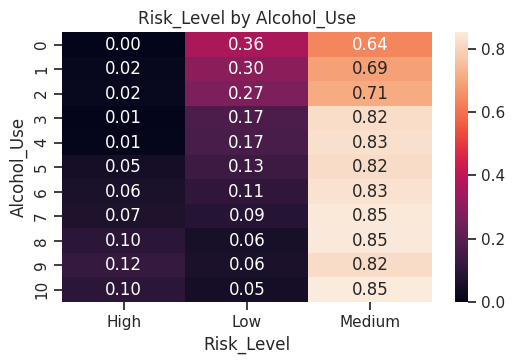

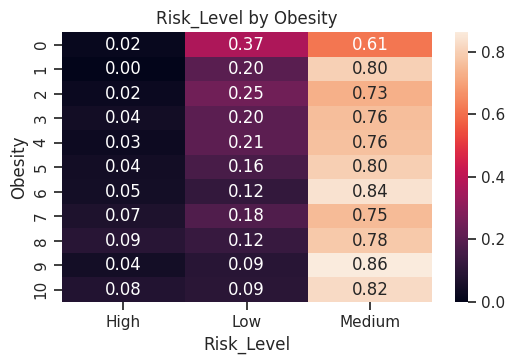

In [5]:
# Work on a sample for heavy plots (for speed)
if len(df) > MAX_ROWS_FOR_PLOTS:
    df_plot = df.sample(MAX_ROWS_FOR_PLOTS, random_state=RANDOM_STATE).copy()
    info(f"Using a sample of {len(df_plot)} rows for heavy plots.")
else:
    df_plot = df.copy()

# --- Numeric distributions ---
num_features = [c for c in ["Age", "BMI", "Overall_Risk_Score"] if c in df_plot.columns]

for col in num_features:
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.histplot(df_plot[col], bins=30, kde=True, ax=ax, color="#4B9CD3")
    ax.set_title(f"{col} Distribution", fontsize=12, fontweight="bold")
    ax.set_xlabel(col)
    plt.tight_layout()
    plt.show()

# --- Categorical target distributions ---
cat_features = [c for c in ["Cancer_Type", "Risk_Level"] if c in df_plot.columns]

for col in cat_features:
    fig, ax = plt.subplots(figsize=(6.5, 4))
    sns.countplot(
        x=col,
        data=df_plot,
        order=df_plot[col].value_counts().index,
        palette="viridis",
        ax=ax
    )
    ax.set_title(f"{col} Distribution", fontsize=12, fontweight="bold")
    ax.tick_params(axis="x", rotation=20)
    plt.tight_layout()
    plt.show()

# --- Correlation matrix (numeric) ---
corr = df_plot.select_dtypes(include=[np.number]).corr(numeric_only=True)
plt.figure(figsize=(9, 7))
sns.heatmap(corr, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Numeric Correlation Matrix", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

# --- Boxplots: numeric vs Cancer_Type ---
if "Cancer_Type" in df_plot.columns:
    for col in num_features:
        fig, ax = plt.subplots(figsize=(7.5, 4))
        sns.boxplot(x="Cancer_Type", y=col, data=df_plot, palette="Set2")
        ax.set_title(f"{col} by Cancer_Type", fontsize=12, fontweight="bold")
        ax.tick_params(axis="x", rotation=20)
        plt.tight_layout()
        plt.show()

# --- Correlation with Overall_Risk_Score ---
if "Overall_Risk_Score" in df_plot.columns:
    target = "Overall_Risk_Score"
    corr_abs = df_plot.corr(numeric_only=True)[target].abs().sort_values(ascending=False)
    plt.figure(figsize=(6.5, 4.5))
    sns.barplot(
        x=corr_abs.values[1:11],
        y=corr_abs.index[1:11],
        palette="coolwarm"
    )
    plt.title(f"Top Correlated Features with {target}", fontsize=12, fontweight="bold")
    plt.xlabel("Absolute correlation")
    plt.tight_layout()
    plt.show()

# --- Cancer_Type within each Risk_Level ---
if all(c in df_plot.columns for c in ["Risk_Level", "Cancer_Type"]):
    cross_tab = pd.crosstab(df_plot["Risk_Level"], df_plot["Cancer_Type"])
    cross_tab_ratio = cross_tab.apply(lambda x: x / x.sum(), axis=1)
    cross_tab_ratio.plot(
        kind="bar", stacked=True, colormap="viridis", figsize=(8, 5), width=0.8
    )
    plt.title("Cancer_Type distribution within each Risk_Level", fontsize=13, fontweight="bold")
    plt.ylabel("Proportion")
    plt.xlabel("Risk_Level")
    plt.legend(title="Cancer_Type", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# --- Age & BMI bins (clinical-style view) ---
if "Age" in df_plot.columns:
    df_plot["Age_Bin"] = pd.cut(
        df_plot["Age"],
        bins=[0, 30, 45, 60, 80, 120],
        labels=["≤30", "31-45", "46-60", "61-80", "80+"]
    )

if "BMI" in df_plot.columns:
    df_plot["BMI_Bin"] = pd.cut(
        df_plot["BMI"],
        bins=[0, 18.5, 25, 30, 40, np.inf],
        labels=["Underweight", "Normal", "Overweight", "Obese", "Severe Obese"]
    )

if "Age_Bin" in df_plot.columns and "Cancer_Type" in df_plot.columns:
    age_risk = pd.crosstab(df_plot["Age_Bin"], df_plot["Cancer_Type"], normalize="index")
    age_risk.plot(kind="bar", stacked=True, figsize=(8, 5), colormap="magma")
    plt.title("Cancer_Type distribution across Age groups")
    plt.ylabel("Proportion")
    plt.xlabel("Age group")
    plt.tight_layout()
    plt.show()

if "BMI_Bin" in df_plot.columns and "Risk_Level" in df_plot.columns:
    bmi_risk = pd.crosstab(df_plot["BMI_Bin"], df_plot["Risk_Level"], normalize="index")

    order = [c for c in ["Low", "Medium", "High"] if c in bmi_risk.columns]
    if order:
        bmi_risk = bmi_risk[order]

    colors = [
        "#22c55e",
        "#eab308",
        "#ef4444",
    ][: len(bmi_risk.columns)]

    bmi_risk.plot(
        kind="bar",
        stacked=True,
        figsize=(8, 5),
        color=colors,
        width=0.8,
    )
    plt.title("Risk_Level distribution across BMI groups")
    plt.ylabel("Proportion")
    plt.xlabel("BMI group")
    plt.tight_layout()
    plt.show()


# --- Lifestyle vs Risk_Level heatmaps ---
lifestyle_cols = [c for c in ["Smoking", "Alcohol_Use", "Obesity"] if c in df_plot.columns]

for col in lifestyle_cols:
    ct = pd.crosstab(df_plot[col], df_plot["Risk_Level"], normalize="index")
    plt.figure(figsize=(5.5, 3.8))
    sns.heatmap(ct, annot=True, fmt=".2f", cmap="rocket")
    plt.title(f"Risk_Level by {col}")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# --- Pairplot ---
if not DISABLE_PAIRPLOT:
    subset_cols = [c for c in ["Age", "BMI", "Smoking", "Alcohol_Use", "Overall_Risk_Score"] if c in df_plot.columns]
    if "Cancer_Type" in df_plot.columns and len(subset_cols) > 1:
        sns.pairplot(
            df_plot[subset_cols + ["Cancer_Type"]],
            hue="Cancer_Type", diag_kind="hist", corner=True, palette="husl"
        )
        plt.suptitle("Pairwise Relationships (colored by Cancer_Type)", y=1.02)
        plt.show()


## Preprocessing & Model Utilities  

We build:

- **OneHotEncoder** with backward/forward compatibility.
- A robust `ColumnTransformer` for numeric + categorical features.
- A generic `evaluate_models` function to run cross-validated comparisons across models.


In [6]:
def _make_ohe():
    """Create OneHotEncoder with backward/forward compatibility for scikit-learn versions."""
    if "sparse_output" in inspect.signature(OneHotEncoder).parameters:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=True, dtype=np.float32)
    else:
        return OneHotEncoder(handle_unknown="ignore", sparse=True, dtype=np.float32)

def build_preprocess(X: pd.DataFrame):
    """Build ColumnTransformer with numeric + categorical preprocessing pipelines."""
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

    numeric_tf = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=False)),
    ])

    categorical_tf = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", _make_ohe()),
    ])

    preprocess = ColumnTransformer(
        transformers=[
            ("num", numeric_tf, num_cols),
            ("cat", categorical_tf, cat_cols),
        ]
    )
    return preprocess, num_cols, cat_cols

def evaluate_models(X, y, scoring="f1_macro", n_splits=5):
    """Evaluate multiple classification models with cross-validation."""
    preprocess, _, _ = build_preprocess(X)
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    models = {
        "LogReg(balanced)": LogisticRegression(
            solver="lbfgs", multi_class="multinomial",
            max_iter=800, C=1.0, class_weight="balanced", random_state=RANDOM_STATE
        ),
        "RandomForest": RandomForestClassifier(
            n_estimators=300 if FAST_MODE else 600,
            max_depth=None, min_samples_leaf=1,
            random_state=RANDOM_STATE, n_jobs=-1
        ),
        "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
    }

    # models (only include if not in FAST_MODE)
    if not FAST_MODE:
        models["CalibratedSVM(LinearSVC)"] = CalibratedClassifierCV(
            estimator=LinearSVC(C=1.0, random_state=RANDOM_STATE),
            method="sigmoid", cv=3
        )

    # Add XGBoost
    if HAVE_XGB:
        models["XGBoost"] = XGBClassifier(
            n_estimators=200 if FAST_MODE else 400,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.9,
            objective="multi:softprob",
            eval_metric="mlogloss",
            tree_method="hist",
            random_state=RANDOM_STATE
        )

    rows = []
    for name, model in models.items():
        info(f"CV for model: {name}")
        pipe = Pipeline(steps=[("preprocess", preprocess), ("clf", model)])
        scores = cross_val_score(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)
        rows.append({
            "model": name,
            "cv_mean": scores.mean(),
            "cv_std": scores.std(),
            "scores": scores
        })

    res = pd.DataFrame(rows).sort_values("cv_mean", ascending=False).reset_index(drop=True)
    return res


## Modeling Task 1 — Predicting `Cancer_Type`  

- Inputs: All non-leaky columns excluding `Cancer_Type`.
- Target: Encoded `Cancer_Type`.
- Metric: **F1-macro** (handles class imbalance better than accuracy).
- Steps:
  - Cross-validated leaderboard across models.
  - Train best model on train split, evaluate on holdout.
  - Confusion matrices.
  - Calibration curve.
  - Permutation importance.
  - Subgroup F1 by Age_Bin.


Leakage check passed — no leaky columns in features for Cancer_Type.
Running cross-validation (Cancer_Type, F1-macro)...
[INFO] CV for model: LogReg(balanced)
[INFO] CV for model: RandomForest
[INFO] CV for model: GradientBoosting
[INFO] CV for model: XGBoost

Cross-validation complete — sorted by F1-macro:


,model,cv_mean,cv_std,scores
0,XGBoost,0.758677,0.024476,"[0.7224342563747985, 0.7947723549197212, 0.771..."
1,RandomForest,0.748536,0.021252,"[0.7238592818680746, 0.7741162788712717, 0.745..."
2,GradientBoosting,0.746949,0.023654,"[0.7117174787721186, 0.7744598542631589, 0.759..."
3,LogReg(balanced),0.717623,0.024818,"[0.674523245922804, 0.7510699391731455, 0.7153..."



 Best model for Cancer_Type (CV F1-macro): XGBoost

 Holdout performance — Cancer_Type
Best model: XGBoost
Accuracy:  0.782
F1-macro:  0.764

Classification report:

              precision    recall  f1-score   support

      Breast       0.80      0.76      0.78        92
       Colon       0.79      0.81      0.80        84
        Lung       0.82      0.90      0.85       105
    Prostate       0.76      0.82      0.79        61
        Skin       0.69      0.53      0.60        58

    accuracy                           0.78       400
   macro avg       0.77      0.76      0.76       400
weighted avg       0.78      0.78      0.78       400



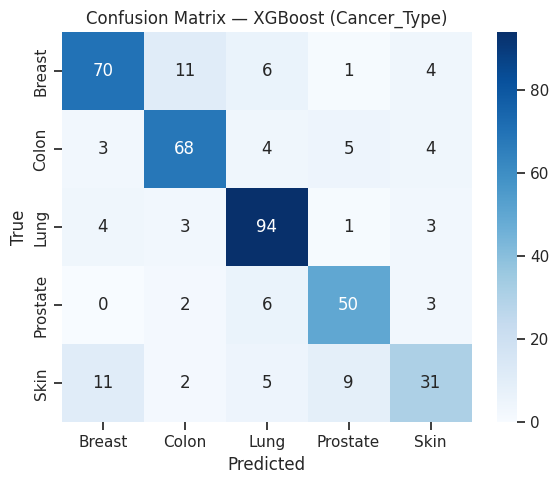

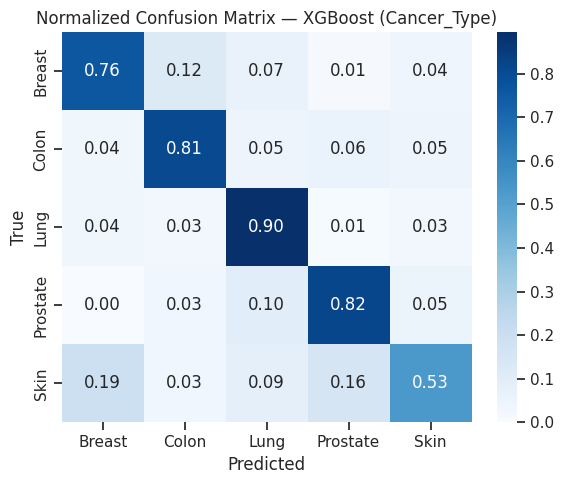

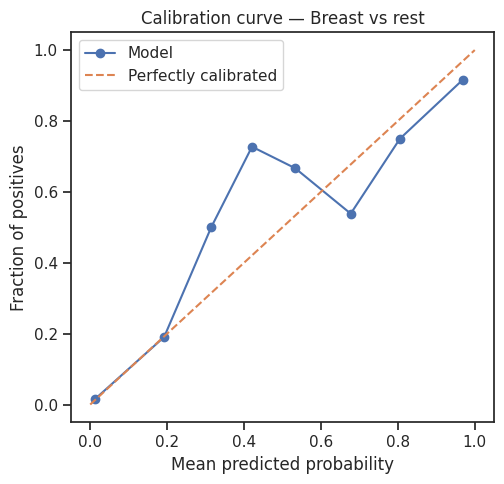

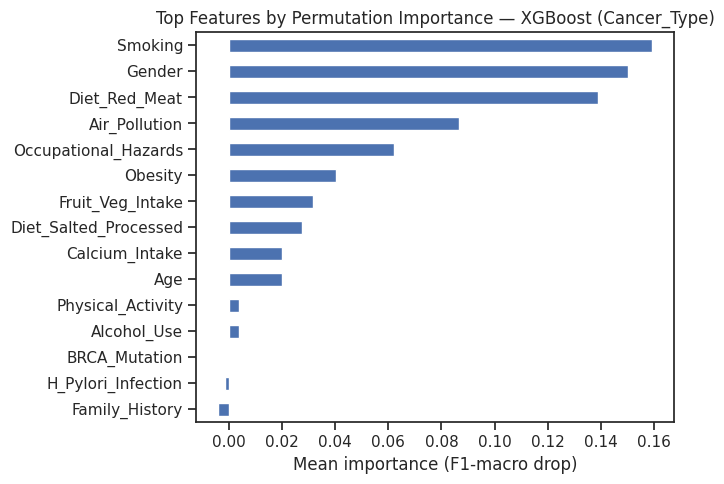


Subgroup F1 by Age_Bin — Cancer_Type
  Age_Bin = ≤30: F1-macro = 1.000
  Age_Bin = 31-45: F1-macro = 0.681
  Age_Bin = 46-60: F1-macro = 0.774
  Age_Bin = 61-80: F1-macro = 0.755
  Age_Bin = 80+: F1-macro = 0.569


In [7]:
target_ct = "Cancer_Type"
features_ct = [c for c in df.columns if c not in [target_ct] + LEAKY_COLS]

X_ct = df[features_ct].copy()
y_ct = df[target_ct].copy()

# Leakage guard
assert set(LEAKY_COLS).isdisjoint(X_ct.columns), "Leakage columns still present in X_ct!"
print("Leakage check passed — no leaky columns in features for Cancer_Type.")

# Encode target
le_ct = LabelEncoder()
y_ct_enc = le_ct.fit_transform(y_ct)

print("Running cross-validation (Cancer_Type, F1-macro)...")
res_ct = evaluate_models(X_ct, y_ct_enc, scoring="f1_macro", n_splits=5)
print("\nCross-validation complete — sorted by F1-macro:")
display(res_ct)

best_name_ct = res_ct.iloc[0]["model"]
print(f"\n Best model for Cancer_Type (CV F1-macro): {best_name_ct}")

# Build preprocess
preprocess_ct, num_ct, cat_ct = build_preprocess(X_ct)

def _get_model_by_name_ct(name):
    if name == "LogReg(balanced)":
        return LogisticRegression(
            solver="lbfgs", multi_class="multinomial",
            max_iter=800, C=1.0, class_weight="balanced", random_state=RANDOM_STATE
        )
    if name == "RandomForest":
        return RandomForestClassifier(
            n_estimators=300 if FAST_MODE else 600,
            max_depth=None, min_samples_leaf=1,
            random_state=RANDOM_STATE, n_jobs=-1
        )
    if name == "GradientBoosting":
        return GradientBoostingClassifier(random_state=RANDOM_STATE)
    if name == "CalibratedSVM(LinearSVC)":
        return CalibratedClassifierCV(
            estimator=LinearSVC(C=1.0, random_state=RANDOM_STATE),
            method="sigmoid", cv=3
        )
    if name == "XGBoost" and HAVE_XGB:
        return XGBClassifier(
            n_estimators=200 if FAST_MODE else 400,
            learning_rate=0.05, max_depth=6,
            subsample=0.9, colsample_bytree=0.9,
            objective="multi:softprob", eval_metric="mlogloss",
            tree_method="hist", random_state=RANDOM_STATE
        )
    raise ValueError(f"Unknown model name: {name}")

best_model_ct = _get_model_by_name_ct(best_name_ct)

# Train / test split
Xtr_ct, Xte_ct, ytr_ct, yte_ct = train_test_split(
    X_ct, y_ct_enc,
    test_size=0.2,
    stratify=y_ct_enc,
    random_state=RANDOM_STATE
)

pipe_ct = Pipeline(steps=[("preprocess", preprocess_ct), ("clf", best_model_ct)])
pipe_ct.fit(Xtr_ct, ytr_ct)
pred_ct = pipe_ct.predict(Xte_ct)

acc_ct = accuracy_score(yte_ct, pred_ct)
f1_ct = f1_score(yte_ct, pred_ct, average="macro")

print("\n Holdout performance — Cancer_Type")
print(f"Best model: {best_name_ct}")
print(f"Accuracy:  {acc_ct:.3f}")
print(f"F1-macro:  {f1_ct:.3f}")
print("\nClassification report:\n")
print(classification_report(yte_ct, pred_ct, target_names=le_ct.classes_))

# Confusion matrices
cm_ct = confusion_matrix(yte_ct, pred_ct)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_ct, annot=True, fmt="d", cmap="Blues",
            xticklabels=le_ct.classes_, yticklabels=le_ct.classes_, ax=ax)
ax.set_title(f"Confusion Matrix — {best_name_ct} (Cancer_Type)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout()
plt.show()

cmn_ct = confusion_matrix(yte_ct, pred_ct, normalize="true")
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cmn_ct, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=le_ct.classes_, yticklabels=le_ct.classes_, ax=ax)
ax.set_title(f"Normalized Confusion Matrix — {best_name_ct} (Cancer_Type)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout()
plt.show()

# Calibration curve (one-vs-rest for a sample class)
if hasattr(pipe_ct, "predict_proba"):
    proba_ct = pipe_ct.predict_proba(Xte_ct)
    class_idx = 0  # first cancer type
    prob_class = proba_ct[:, class_idx]
    frac_pos, mean_pred = calibration_curve(
        (yte_ct == class_idx).astype(int),
        prob_class,
        n_bins=8
    )

    plt.figure(figsize=(5.2, 5))
    plt.plot(mean_pred, frac_pos, marker="o", label="Model")
    plt.plot([0, 1], [0, 1], "--", label="Perfectly calibrated")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(f"Calibration curve — {le_ct.classes_[class_idx]} vs rest")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Permutation importance
try:
    imp_ct = permutation_importance(
        pipe_ct,
        Xte_ct.reset_index(drop=True),
        yte_ct,
        scoring="f1_macro",
        n_repeats=10,
        random_state=RANDOM_STATE
    )
    raw_features_ct = Xtr_ct.columns.tolist()
    importances_ct = pd.Series(
        imp_ct.importances_mean[:len(raw_features_ct)],
        index=raw_features_ct
    ).sort_values(ascending=False).head(15)

    plt.figure(figsize=(7, 5))
    importances_ct[::-1].plot(kind="barh")
    plt.title(f"Top Features by Permutation Importance — {best_name_ct} (Cancer_Type)")
    plt.xlabel("Mean importance (F1-macro drop)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Permutation importance for Cancer_Type failed:", e)

# Subgroup F1 by Age_Bin
def subgroup_f1_report(X, y_true, y_pred, group_col, df_source, label_encoder, title):
    tmp = df_source.loc[X.index].copy()
    tmp["y_true"] = label_encoder.inverse_transform(y_true)
    tmp["y_pred"] = label_encoder.inverse_transform(y_pred)
    print(f"\nSubgroup F1 by {group_col} — {title}")
    for g, grp in tmp.groupby(group_col):
        f1 = f1_score(grp["y_true"], grp["y_pred"], average="macro")
        print(f"  {group_col} = {g}: F1-macro = {f1:.3f}")

# Rebuild Age_Bin on full df (if Age exists)
if "Age" in df.columns:
    df["Age_Bin"] = pd.cut(
        df["Age"],
        bins=[0, 30, 45, 60, 80, 120],
        labels=["≤30", "31-45", "46-60", "61-80", "80+"]
    )

if "Age_Bin" in df.columns:
    subgroup_f1_report(Xte_ct, yte_ct, pred_ct, "Age_Bin", df, le_ct, "Cancer_Type")


## Modeling Task 2 — Predicting `Risk_Level`  

- Inputs: All non-leaky columns excluding `Risk_Level` and `Cancer_Type`.
- Target: Encoded `Risk_Level`.
- Metric: **F1-macro**.
- Same structure as before: CV leaderboard → holdout → diagnostics.


 Leakage check passed — no leaky columns in features for Risk_Level.
Running cross-validation (Risk_Level, F1-macro)...
[INFO] CV for model: LogReg(balanced)
[INFO] CV for model: RandomForest
[INFO] CV for model: GradientBoosting
[INFO] CV for model: XGBoost

Cross-validation complete — sorted by F1-macro:


,model,cv_mean,cv_std,scores
0,LogReg(balanced),0.708367,0.048225,"[0.728290820561058, 0.6181715124175708, 0.7497..."
1,GradientBoosting,0.662863,0.050640,"[0.6876228552390472, 0.6677335533696683, 0.677..."
2,XGBoost,0.623417,0.062159,"[0.6187672436852766, 0.619248324062188, 0.6740..."
3,RandomForest,0.481208,0.020864,"[0.47038496095099863, 0.5048533247291012, 0.48..."



 Best model for Risk_Level (CV F1-macro): LogReg(balanced)

 Holdout performance — Risk_Level
Best model: LogReg(balanced)
Accuracy:  0.828
F1-macro:  0.715

Classification report:

              precision    recall  f1-score   support

        High       0.33      0.85      0.48        20
         Low       0.70      0.89      0.78        65
      Medium       0.96      0.81      0.88       315

    accuracy                           0.83       400
   macro avg       0.66      0.85      0.71       400
weighted avg       0.89      0.83      0.85       400



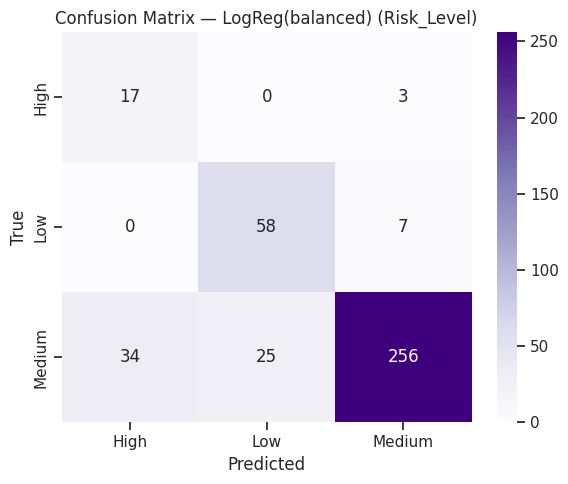

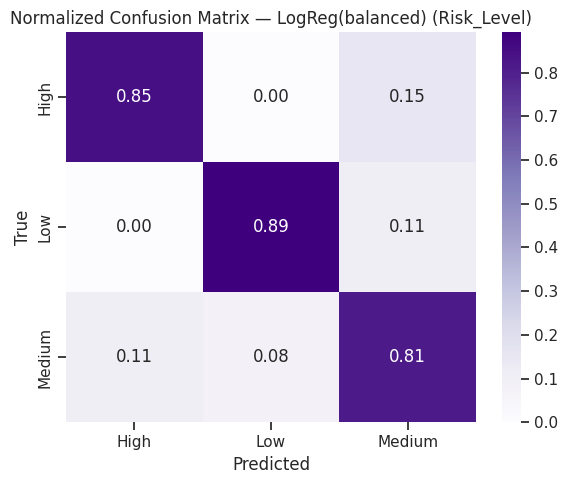

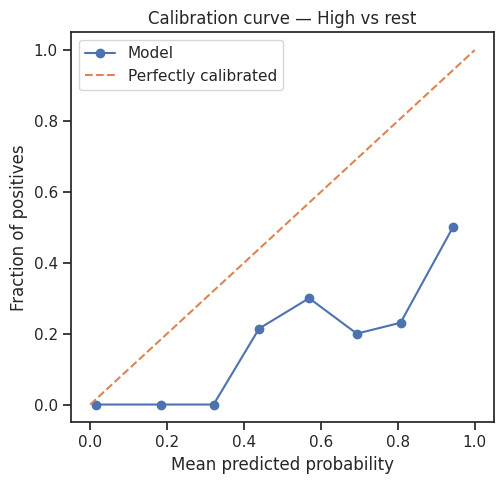

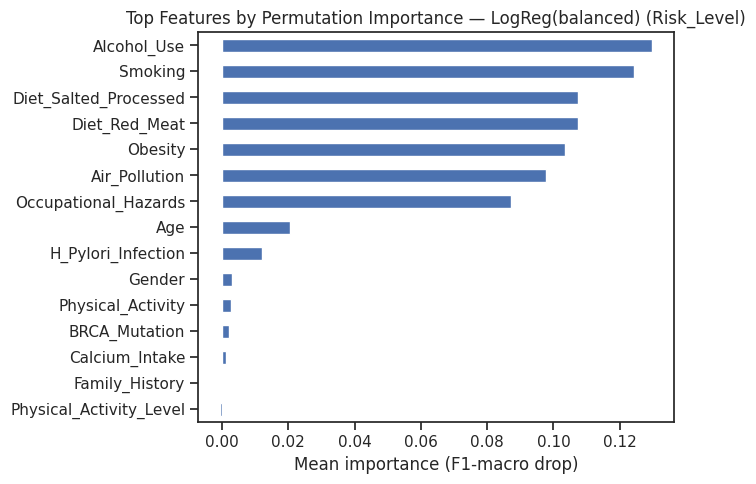

In [8]:

target_rl = "Risk_Level"
features_rl = [c for c in df.columns if c not in [target_rl, "Overall_Risk_Score", "Cancer_Type"]]

X_rl = df[features_rl].copy()
y_rl = df[target_rl].copy()

assert "Overall_Risk_Score" not in X_rl.columns and "Cancer_Type" not in X_rl.columns, \
    "Leakage risk in X_rl!"
print(" Leakage check passed — no leaky columns in features for Risk_Level.")

# Encode target
le_rl = LabelEncoder()
y_rl_enc = le_rl.fit_transform(y_rl)

print("Running cross-validation (Risk_Level, F1-macro)...")
res_rl = evaluate_models(X_rl, y_rl_enc, scoring="f1_macro", n_splits=5)
print("\nCross-validation complete — sorted by F1-macro:")
display(res_rl)

best_name_rl = res_rl.iloc[0]["model"]
print(f"\n Best model for Risk_Level (CV F1-macro): {best_name_rl}")

preprocess_rl, num_rl, cat_rl = build_preprocess(X_rl)

def _get_model_by_name_rl(name):
    if name == "LogReg(balanced)":
        return LogisticRegression(
            solver="lbfgs", multi_class="multinomial",
            max_iter=800, C=1.0, class_weight="balanced", random_state=RANDOM_STATE
        )
    if name == "RandomForest":
        return RandomForestClassifier(
            n_estimators=300 if FAST_MODE else 600,
            max_depth=None, min_samples_leaf=1,
            random_state=RANDOM_STATE, n_jobs=-1
        )
    if name == "GradientBoosting":
        return GradientBoostingClassifier(random_state=RANDOM_STATE)
    if name == "CalibratedSVM(LinearSVC)":
        return CalibratedClassifierCV(
            estimator=LinearSVC(C=1.0, random_state=RANDOM_STATE),
            method="sigmoid", cv=3
        )
    if name == "XGBoost" and HAVE_XGB:
        return XGBClassifier(
            n_estimators=200 if FAST_MODE else 400,
            learning_rate=0.05, max_depth=6,
            subsample=0.9, colsample_bytree=0.9,
            objective="multi:softprob", eval_metric="mlogloss",
            tree_method="hist", random_state=RANDOM_STATE
        )
    raise ValueError(f"Unknown model name: {name}")

best_model_rl = _get_model_by_name_rl(best_name_rl)

# Train / test split
Xtr_rl, Xte_rl, ytr_rl, yte_rl = train_test_split(
    X_rl, y_rl_enc,
    test_size=0.2,
    stratify=y_rl_enc,
    random_state=RANDOM_STATE
)

pipe_rl = Pipeline(steps=[("preprocess", preprocess_rl), ("clf", best_model_rl)])
pipe_rl.fit(Xtr_rl, ytr_rl)
pred_rl = pipe_rl.predict(Xte_rl)

acc_rl = accuracy_score(yte_rl, pred_rl)
f1_rl = f1_score(yte_rl, pred_rl, average="macro")

print("\n Holdout performance — Risk_Level")
print(f"Best model: {best_name_rl}")
print(f"Accuracy:  {acc_rl:.3f}")
print(f"F1-macro:  {f1_rl:.3f}")
print("\nClassification report:\n")
print(classification_report(yte_rl, pred_rl, target_names=le_rl.classes_))

# Confusion matrices
cm_rl = confusion_matrix(yte_rl, pred_rl)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_rl, annot=True, fmt="d", cmap="Purples",
            xticklabels=le_rl.classes_, yticklabels=le_rl.classes_, ax=ax)
ax.set_title(f"Confusion Matrix — {best_name_rl} (Risk_Level)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout()
plt.show()

cmn_rl = confusion_matrix(yte_rl, pred_rl, normalize="true")
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cmn_rl, annot=True, fmt=".2f", cmap="Purples",
            xticklabels=le_rl.classes_, yticklabels=le_rl.classes_, ax=ax)
ax.set_title(f"Normalized Confusion Matrix — {best_name_rl} (Risk_Level)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout()
plt.show()

# Calibration curve (one-vs-rest for a sample class)
if hasattr(pipe_rl, "predict_proba"):
    proba_rl = pipe_rl.predict_proba(Xte_rl)
    class_idx_rl = 0  # first risk level
    prob_class_rl = proba_rl[:, class_idx_rl]
    frac_pos_rl, mean_pred_rl = calibration_curve(
        (yte_rl == class_idx_rl).astype(int),
        prob_class_rl,
        n_bins=8
    )

    plt.figure(figsize=(5.2, 5))
    plt.plot(mean_pred_rl, frac_pos_rl, marker="o", label="Model")
    plt.plot([0, 1], [0, 1], "--", label="Perfectly calibrated")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(f"Calibration curve — {le_rl.classes_[class_idx_rl]} vs rest")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Permutation importance
try:
    imp_rl = permutation_importance(
        pipe_rl,
        Xte_rl.reset_index(drop=True),
        yte_rl,
        scoring="f1_macro",
        n_repeats=10,
        random_state=RANDOM_STATE
    )
    raw_features_rl = Xtr_rl.columns.tolist()
    importances_rl = pd.Series(
        imp_rl.importances_mean[:len(raw_features_rl)],
        index=raw_features_rl
    ).sort_values(ascending=False).head(15)

    plt.figure(figsize=(7, 5))
    importances_rl[::-1].plot(kind="barh")
    plt.title(f"Top Features by Permutation Importance — {best_name_rl} (Risk_Level)")
    plt.xlabel("Mean importance (F1-macro drop)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Permutation importance for Risk_Level failed:", e)


## Unified Summary — CV vs Holdout  

We summarize the best models and performance for both targets  
and compare to dummy baselines.


In [9]:
summary_rows = []

summary_rows.append({
    "target": "Cancer_Type",
    "best_model": best_name_ct,
    "cv_f1_macro": float(res_ct.iloc[0]["cv_mean"]),
    "holdout_acc": float(acc_ct),
    "holdout_f1_macro": float(f1_ct),
})

summary_rows.append({
    "target": "Risk_Level",
    "best_model": best_name_rl,
    "cv_f1_macro": float(res_rl.iloc[0]["cv_mean"]),
    "holdout_acc": float(acc_rl),
    "holdout_f1_macro": float(f1_rl),
})

summary_df = pd.DataFrame(summary_rows)
print(" Model summary (per target):")
display(summary_df)


 Model summary (per target):


,target,best_model,cv_f1_macro,holdout_acc,holdout_f1_macro
0,Cancer_Type,XGBoost,0.758677,0.7825,0.764333
1,Risk_Level,LogReg(balanced),0.708367,0.8275,0.714632


## Hyperparameter Tuning (RandomForest on Cancer_Type)  

To show how performance can be improved beyond defaults,  
we run a lightweight randomized search on **RandomForest** for `Cancer_Type`.


In [10]:

if not FAST_MODE:
    preprocess_ct_tune, _, _ = build_preprocess(X_ct)

    rf_base = RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    param_dist = {
        "clf__n_estimators": randint(200, 800),
        "clf__max_depth": randint(3, 20),
        "clf__min_samples_leaf": randint(1, 6),
    }

    pipe_rf = Pipeline(steps=[("preprocess", preprocess_ct_tune), ("clf", rf_base)])

    search = RandomizedSearchCV(
        pipe_rf,
        param_distributions=param_dist,
        n_iter=20,
        scoring="f1_macro",
        cv=5,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=1
    )

    search.fit(X_ct, y_ct_enc)
    print("Best RF params:", search.best_params_)
    print("Best CV F1-macro:", search.best_score_)
else:
    print("FAST_MODE=True → Skipping hyperparameter tuning section.")


FAST_MODE=True → Skipping hyperparameter tuning section.


## Production Touch — Export & Single-Patient Prediction  

We export the trained pipelines and label encoders,  
and provide a simple helper to predict for a single patient record  
(as a dictionary or one-row DataFrame).


In [11]:

def predict_cancer_type(model, label_encoder, sample: dict):
    X_new = pd.DataFrame([sample])
    pred_enc = model.predict(X_new)[0]
    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_new)[0].max()
    return {
        "predicted_class": label_encoder.inverse_transform([pred_enc])[0],
        "confidence": float(proba) if proba is not None else None
    }

def predict_risk_level(model, label_encoder, sample: dict):
    X_new = pd.DataFrame([sample])
    pred_enc = model.predict(X_new)[0]
    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_new)[0].max()
    return {
        "predicted_risk": label_encoder.inverse_transform([pred_enc])[0],
        "confidence": float(proba) if proba is not None else None
    }

# Build a demo patient from the first row (features only)
example_patient_ct = {c: df[c].iloc[0] for c in X_ct.columns}
example_patient_rl = {c: df[c].iloc[0] for c in X_rl.columns}

print("Example prediction — Cancer_Type:")
print(predict_cancer_type(pipe_ct, le_ct, example_patient_ct))

print("\nExample prediction — Risk_Level:")
print(predict_risk_level(pipe_rl, le_rl, example_patient_rl))

# Export artifacts
if HAVE_JOBLIB:
    os.makedirs("artifacts", exist_ok=True)
    joblib.dump(pipe_ct, "artifacts/cancer_type_model.joblib")
    joblib.dump(le_ct, "artifacts/cancer_type_label_encoder.joblib")
    joblib.dump(pipe_rl, "artifacts/risk_level_model.joblib")
    joblib.dump(le_rl, "artifacts/risk_level_label_encoder.joblib")
    print("\n Saved models and label encoders to 'artifacts/' directory.")
else:
    print("\n joblib not available — skipping model export.")


Example prediction — Cancer_Type:
{'predicted_class': 'Breast', 'confidence': 0.8440125584602356}

Example prediction — Risk_Level:
{'predicted_risk': 'Medium', 'confidence': 0.8629520353172552}

 Saved models and label encoders to 'artifacts/' directory.


## Summary & Next Steps  

<style>
:root{
  --card-bg: linear-gradient(135deg, #ffffff 0%, #f1f5f9 45%, #e2e8f0 100%);
  --card-fg: #0f172a;
  --card-border: rgba(15,23,42,0.18);
  --card-shadow: 0 0 40px rgba(2,6,23,0.10);
  --code-bg: rgba(148,163,184,0.22);
}
@media (prefers-color-scheme: dark){
  :root{
    --card-bg: linear-gradient(135deg, #020617 0%, #0f172a 45%, #1f2937 100%);
    --card-fg: #e5e7eb;
    --card-border: rgba(148,163,184,0.35);
    --card-shadow: 0 0 40px rgba(15,23,42,0.75);
    --code-bg: rgba(148,163,184,0.20);
  }
}
html[data-color-mode="dark"],
html[data-theme="dark"],
body[data-theme="dark"],
body.theme-dark,
html.theme-dark{
  --card-bg: linear-gradient(135deg, #020617 0%, #0f172a 45%, #1f2937 100%);
  --card-fg: #e5e7eb;
  --card-border: rgba(148,163,184,0.35);
  --card-shadow: 0 0 40px rgba(15,23,42,0.75);
  --code-bg: rgba(148,163,184,0.20);
}
html[data-color-mode="light"],
html[data-theme="light"],
body[data-theme="light"],
body.theme-light,
html.theme-light{
  --card-bg: linear-gradient(135deg, #ffffff 0%, #f1f5f9 45%, #e2e8f0 100%);
  --card-fg: #0f172a;
  --card-border: rgba(15,23,42,0.18);
  --card-shadow: 0 0 40px rgba(2,6,23,0.10);
  --code-bg: rgba(148,163,184,0.22);
}
.kgl-card{
  padding:26px 30px;
  background:var(--card-bg) !important;
  border-radius:18px;
  border:1px solid var(--card-border) !important;
  color:var(--card-fg) !important;
  line-height:1.7;
  margin:26px 0 34px 0;
  box-shadow:var(--card-shadow) !important;
}
.kgl-card *{
  color:var(--card-fg) !important;
}
.kgl-card code{
  background:var(--code-bg) !important;
  padding:2px 6px !important;
  border-radius:6px !important;
}
</style>

<div class="kgl-card">

<h2 style="margin:0 0 14px 0; font-size:22px; font-weight:800;">
From notebook to reusable tool
</h2>

<p style="margin:0 0 14px 0;">
By the end of this workflow, raw cancer risk factors have been turned into two 
<b>leakage-audited, calibrated pipelines</b> that can score a single patient for both 
<code>Cancer_Type</code> and <code>Risk_Level</code>. The models are not just accurate – they are 
backed by diagnostics that make their behavior inspectable and easier to trust.
</p>

<h3 style="margin:4px 0 8px 0; font-size:15px; font-weight:700;">
What you have now
</h3>

<ul style="margin:0 0 10px 1.1rem; padding:0;">
  <li style="margin:3px 0;">
    Trained pipelines for <code>Cancer_Type</code> and <code>Risk_Level</code> with macro-F1–based model selection.
  </li>
  <li style="margin:3px 0;">
    Explicit leakage checks for <code>Risk_Level</code> and <code>Overall_Risk_Score</code>.
  </li>
  <li style="margin:3px 0;">
    Confusion matrices, calibration curves, permutation importance, and subgroup metrics by age.
  </li>
  <li style="margin:3px 0;">
    Exportable artifacts and helper functions to score individual patients outside the notebook.
  </li>
</ul>

<h3 style="margin:6px 0 8px 0; font-size:15px; font-weight:700;">
How to reuse it
</h3>

<ul style="margin:0 0 10px 1.1rem; padding:0;">
  <li style="margin:3px 0;">
    Wrap the saved models in a small <b>API or Streamlit app</b> to demo risk predictions interactively.
  </li>
  <li style="margin:3px 0;">
    Swap in a different healthcare-style dataset by aligning feature names and re-running the same pipeline.
  </li>
  <li style="margin:3px 0;">
    Extend the feature set (e.g., additional lab results or imaging-derived scores) and compare performance.
  </li>
</ul>

<h3 style="margin:6px 0 8px 0; font-size:15px; font-weight:700;">
Next steps for a production-grade version
</h3>

<ul style="margin:0 0 0 1.1rem; padding:0;">
  <li style="margin:3px 0;">
    Add <b>SHAP-based local explanations</b> so each prediction comes with case-level reasoning.
  </li>
  <li style="margin:3px 0;">
    Introduce basic <b>monitoring</b>: track drift, calibration, and class balance as new data arrives.
  </li>
  <li style="margin:3px 0;">
    When longitudinal outcomes are available, explore <b>survival / time-to-event models</b>.
  </li>
</ul>

</div>
